In [44]:
# Importing built-in libraries 

import os
import re
import unicodedata
from time import gmtime, strftime
from datetime import datetime, timedelta
import glob
from langchain.text_splitter import Language, RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings

import warnings
warnings.filterwarnings("ignore")

# Importing libraries you need to install
import requests
from lxml import html
import bs4 as bs
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from gensim import corpora
from gensim.models import TfidfModel, LdaMulticore
from wordcloud import WordCloud
import pyLDAvis.gensim
from datetime import datetime
from collections import Counter
import seaborn as sns
from textblob import TextBlob
import pandas_datareader.data as web
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ameiy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Downloading Data of Specified Ticker from EDGAR + GUI

In [45]:
from tkinter import Tk, Label, Entry, Button
from sec_edgar_downloader import Downloader

def download_10k_reports():
    ticker = entry_ticker.get()

    # Download the 10-K reports
    dl = Downloader("AAAA", "AAAA@gmail.com", "C:\\Users\\ameiy\\Documents\\4_Personal_Projects\\llm\\Data28_04")
    dl.get("10-K", ticker, after="1995-01-01", before="2023-03-25")

    # Terminate the window after download
    window.destroy()

# Create the main window
window = Tk()
window.title("10-K Report Downloader")

# Create and position the ticker symbol label and entry field
label_ticker = Label(window, text="Ticker Symbol:")
label_ticker.pack()
entry_ticker = Entry(window, width=60)  # Adjust the width here
entry_ticker.pack()

# Create and position the download button
button_download = Button(window, text="Download", command=download_10k_reports)
button_download.pack()

# Start the main loop
window.mainloop()

# Cleaning Data

In [46]:
def DelTags(file_soup):
    # Remove HTML tags 
    doc = file_soup.get_text()
    
    # Remove newline characters
    doc = doc.replace('\n', ' ')
    
    # Replace unicode characters 
    doc = unicodedata.normalize('NFKD', doc)
    
    return doc

def DelTables(file_soup):
    def GetDigitPercentage(tablestring):
        if len(tablestring) > 0.0:
            numbers = sum([char.isdigit() for char in tablestring])
            length = len(tablestring)
            return numbers/length
        else:
            return 1
    
    # Remove tables with >15% numeric content
    [x.extract() for x in file_soup.find_all('table') if GetDigitPercentage(x.get_text()) > 0.15]
    
    return file_soup

def ConvertHTML(cik_dir):
    print(f"Parsing 10-Ks in {cik_dir}...")
    
    # Make textonly directory if it doesn't exist
    textonly_dir = os.path.join(cik_dir, 'textonly') 
    os.makedirs(textonly_dir, exist_ok=True)
    
    # Get list of 10-K HTML files
    html_files = [f for f in os.listdir(cik_dir) if f.endswith('.txt')]
    
    for html_file in html_files:
        # Skip if already processed
        txt_file = html_file.replace('.txt', '_clean.txt')
        if txt_file in os.listdir(textonly_dir):
            continue
        
        # Read HTML file 
        with open(os.path.join(cik_dir, html_file), 'r') as f:
            soup = bs.BeautifulSoup(f.read(), "lxml")
        
        # Remove tables and tags
        soup = DelTables(soup) 
        text = DelTags(soup)
        
        # Write cleaned text to file
        with open(os.path.join(textonly_dir, txt_file), 'w') as f:
            f.write(text)

# Iterate over CIKs and clean HTML filings            
for cik_dir in tqdm(glob.glob('Data28_04/sec-edgar-filings/*/10-K/*/')):
    ConvertHTML(cik_dir)


  0%|          | 0/26 [00:00<?, ?it/s]

Parsing 10-Ks in Data28_04/sec-edgar-filings\AAPL\10-K\0000320193-17-000070\...


  4%|▍         | 1/26 [00:06<02:37,  6.31s/it]

Parsing 10-Ks in Data28_04/sec-edgar-filings\AAPL\10-K\0000320193-18-000145\...


  8%|▊         | 2/26 [00:11<02:10,  5.42s/it]

Parsing 10-Ks in Data28_04/sec-edgar-filings\AAPL\10-K\0000320193-19-000119\...


 12%|█▏        | 3/26 [00:20<02:50,  7.43s/it]

Parsing 10-Ks in Data28_04/sec-edgar-filings\AAPL\10-K\0000320193-20-000096\...


 15%|█▌        | 4/26 [00:32<03:23,  9.25s/it]

Parsing 10-Ks in Data28_04/sec-edgar-filings\AAPL\10-K\0000320193-21-000105\...


 19%|█▉        | 5/26 [00:37<02:35,  7.42s/it]

Parsing 10-Ks in Data28_04/sec-edgar-filings\AAPL\10-K\0000320193-22-000108\...


 31%|███       | 8/26 [00:41<00:57,  3.20s/it]

Parsing 10-Ks in Data28_04/sec-edgar-filings\AAPL\10-K\0000320193-95-000016\...
Parsing 10-Ks in Data28_04/sec-edgar-filings\AAPL\10-K\0000320193-96-000023\...
Parsing 10-Ks in Data28_04/sec-edgar-filings\AAPL\10-K\0000912057-00-053623\...


 38%|███▊      | 10/26 [00:41<00:30,  1.91s/it]

Parsing 10-Ks in Data28_04/sec-edgar-filings\AAPL\10-K\0000912057-99-010244\...
Parsing 10-Ks in Data28_04/sec-edgar-filings\AAPL\10-K\0001047469-02-007674\...


 42%|████▏     | 11/26 [00:43<00:27,  1.85s/it]

Parsing 10-Ks in Data28_04/sec-edgar-filings\AAPL\10-K\0001047469-03-041604\...


 46%|████▌     | 12/26 [00:47<00:33,  2.40s/it]

Parsing 10-Ks in Data28_04/sec-edgar-filings\AAPL\10-K\0001047469-04-035975\...


 50%|█████     | 13/26 [00:48<00:26,  2.04s/it]

Parsing 10-Ks in Data28_04/sec-edgar-filings\AAPL\10-K\0001047469-07-009340\...


 54%|█████▍    | 14/26 [00:49<00:21,  1.78s/it]

Parsing 10-Ks in Data28_04/sec-edgar-filings\AAPL\10-K\0001047469-97-006960\...
Parsing 10-Ks in Data28_04/sec-edgar-filings\AAPL\10-K\0001104659-05-058421\...


 62%|██████▏   | 16/26 [00:51<00:14,  1.40s/it]

Parsing 10-Ks in Data28_04/sec-edgar-filings\AAPL\10-K\0001104659-06-084288\...


 65%|██████▌   | 17/26 [00:54<00:16,  1.88s/it]

Parsing 10-Ks in Data28_04/sec-edgar-filings\AAPL\10-K\0001193125-08-224958\...


 69%|██████▉   | 18/26 [00:55<00:12,  1.59s/it]

Parsing 10-Ks in Data28_04/sec-edgar-filings\AAPL\10-K\0001193125-09-214859\...


 73%|███████▎  | 19/26 [00:57<00:12,  1.74s/it]

Parsing 10-Ks in Data28_04/sec-edgar-filings\AAPL\10-K\0001193125-10-238044\...


 77%|███████▋  | 20/26 [01:05<00:21,  3.58s/it]

Parsing 10-Ks in Data28_04/sec-edgar-filings\AAPL\10-K\0001193125-11-282113\...


 81%|████████  | 21/26 [01:11<00:20,  4.14s/it]

Parsing 10-Ks in Data28_04/sec-edgar-filings\AAPL\10-K\0001193125-12-444068\...


 85%|████████▍ | 22/26 [01:17<00:19,  4.87s/it]

Parsing 10-Ks in Data28_04/sec-edgar-filings\AAPL\10-K\0001193125-13-416534\...


 88%|████████▊ | 23/26 [01:33<00:23,  7.93s/it]

Parsing 10-Ks in Data28_04/sec-edgar-filings\AAPL\10-K\0001193125-14-383437\...


 92%|█████████▏| 24/26 [01:47<00:19,  9.61s/it]

Parsing 10-Ks in Data28_04/sec-edgar-filings\AAPL\10-K\0001193125-15-356351\...


 96%|█████████▌| 25/26 [01:54<00:09,  9.09s/it]

Parsing 10-Ks in Data28_04/sec-edgar-filings\AAPL\10-K\0001628280-16-020309\...


100%|██████████| 26/26 [02:00<00:00,  4.64s/it]


# Extracting section-wise info of Item 1a, 7, 7

In [47]:
import os
import glob
import pandas as pd
import re
from bs4 import BeautifulSoup

# Regex patterns
doc_start_pattern = re.compile(r'<DOCUMENT>')
doc_end_pattern = re.compile(r'</DOCUMENT>')
type_pattern = re.compile(r'<TYPE>[^\n]+')
regex = re.compile(r'(>Item(\s|&#160;|&nbsp;)(1A|1B|2|7A|7|8)\.{0,1})|(ITEM\s(1A|1B|2|7A|7|8))')

# Define the directory path where the files are stored
directory_path = 'C:/Users/ameiy/Documents/4_Personal_Projects/llm/Data28_04/sec-edgar-filings/AAPL/10-K/'

# Manually populate the file_paths list by iterating through the files
file_paths = []
for root, dirs, files in os.walk(directory_path):
    for file in files:
        if file == 'full-submission.txt':
            file_path = os.path.join(root, file)
            file_paths.append(file_path)

### Item 1A

In [69]:
# Function to extract data from a file
def extract_data(file_path):
    with open(file_path, 'r') as file:
        raw_10k = file.read()

    doc_start_is = [x.end() for x in doc_start_pattern.finditer(raw_10k)]
    doc_end_is = [x.start() for x in doc_end_pattern.finditer(raw_10k)]
    doc_types = [x[len('<TYPE>'):] for x in type_pattern.findall(raw_10k)]

    document = {}
    for doc_type, doc_start, doc_end in zip(doc_types, doc_start_is, doc_end_is):
        if doc_type == '10-K':
            document[doc_type] = raw_10k[doc_start:doc_end]

    matches = regex.finditer(document['10-K'])
    match_list = [(match.group(), match.start(), match.end()) for match in matches]

    test_df = pd.DataFrame(match_list, columns=['item', 'start', 'end'])
    test_df['item'] = test_df.item.str.lower()

    test_df.replace('&#160;', ' ', regex=True, inplace=True)
    test_df.replace('&nbsp;', ' ', regex=True, inplace=True)
    test_df.replace(' ', '', regex=True, inplace=True)
    test_df.replace('\.', '', regex=True, inplace=True)
    test_df.replace('>', '', regex=True, inplace=True)

    pos_dat = test_df.sort_values('start', ascending=True).drop_duplicates(subset=['item'], keep='last')
    pos_dat.set_index('item', inplace=True)

    try:
        item_1a_raw = document['10-K'][pos_dat['start'].loc['item1a']:pos_dat['start'].loc['item1b']]
        # item_7_raw = document['10-K'][pos_dat['start'].loc['item7']:pos_dat['start'].loc['item7a']]
        # item_7a_raw = document['10-K'][pos_dat['start'].loc['item7a']:pos_dat['start'].loc['item8']]

        item_1a_content = BeautifulSoup(item_1a_raw, 'lxml')
        item_1a_text = item_1a_content.get_text("\n\n")[:]
        # item_7_content = BeautifulSoup(item_7_raw, 'lxml')
        # item_7_text = item_7_content.get_text("\n\n")[:]
        # item_7a_content = BeautifulSoup(item_7a_raw, 'lxml')
        # item_7a_text = item_7a_content.get_text("\n\n")[:]


        # Extract and store any other desired information from the file
        # Create a new file name
        output_file_path = os.path.join(os.path.dirname(file_path), 'item_1a.txt')
        # Write the output to a new file in the same directory
        with open(output_file_path, 'w') as output_file:
            output_file.write(item_1a_text)
            
        return item_1a_text 
        
    except KeyError:
        print(f"Skipping file: {file_path}. 'item1a' not found.")
        return None

# Iterate through the file_paths and apply the extract_data function to each file
for file_path in file_paths:
    item_1a_text = extract_data(file_path)
    if item_1a_text is not None:
        print(item_1a_text)
        print('------')

### Item 7

In [70]:
# Function to extract data from a file
def extract_data(file_path):
    with open(file_path, 'r') as file:
        raw_10k = file.read()

    doc_start_is = [x.end() for x in doc_start_pattern.finditer(raw_10k)]
    doc_end_is = [x.start() for x in doc_end_pattern.finditer(raw_10k)]
    doc_types = [x[len('<TYPE>'):] for x in type_pattern.findall(raw_10k)]

    document = {}
    for doc_type, doc_start, doc_end in zip(doc_types, doc_start_is, doc_end_is):
        if doc_type == '10-K':
            document[doc_type] = raw_10k[doc_start:doc_end]

    matches = regex.finditer(document['10-K'])
    match_list = [(match.group(), match.start(), match.end()) for match in matches]

    test_df = pd.DataFrame(match_list, columns=['item', 'start', 'end'])
    test_df['item'] = test_df.item.str.lower()

    test_df.replace('&#160;', ' ', regex=True, inplace=True)
    test_df.replace('&nbsp;', ' ', regex=True, inplace=True)
    test_df.replace(' ', '', regex=True, inplace=True)
    test_df.replace('\.', '', regex=True, inplace=True)
    test_df.replace('>', '', regex=True, inplace=True)

    pos_dat = test_df.sort_values('start', ascending=True).drop_duplicates(subset=['item'], keep='last')
    pos_dat.set_index('item', inplace=True)

    try:
        # item_1a_raw = document['10-K'][pos_dat['start'].loc['item1a']:pos_dat['start'].loc['item1b']]
        item_7_raw = document['10-K'][pos_dat['start'].loc['item7']:pos_dat['start'].loc['item7a']]
        # item_7a_raw = document['10-K'][pos_dat['start'].loc['item7a']:pos_dat['start'].loc['item8']]

        # item_1a_content = BeautifulSoup(item_1a_raw, 'lxml')
        # item_1a_text = item_1a_content.get_text("\n\n")[:]
        item_7_content = BeautifulSoup(item_7_raw, 'lxml')
        item_7_text = item_7_content.get_text("\n\n")[:]
        # item_7a_content = BeautifulSoup(item_7a_raw, 'lxml')
        # item_7a_text = item_7a_content.get_text("\n\n")[:]
        # item_1a_content = BeautifulSoup(item_1a_raw, 'lxml')
        # item_1a_text = item_1a_content.get_text("\n\n")[0:1500]

        # Extract and store any other desired information from the file
        # Create a new file name
        output_file_path = os.path.join(os.path.dirname(file_path), 'item_7.txt')
        # Write the output to a new file in the same directory
        with open(output_file_path, 'w') as output_file:
            output_file.write(item_7_text)

        return item_7_text 
        
    except KeyError:
        print(f"Skipping file: {file_path}. 'item1a' not found.")
        return None

# Iterate through the file_paths and apply the extract_data function to each file
for file_path in file_paths:
    item_7_text = extract_data(file_path)
    if item_1a_text is not None:
        # print(item_1a_text)
        print(item_7_text)
        # print(item_7a_text)
        print('------')

### Item 7A

In [71]:
# Function to extract data from a file
def extract_data(file_path):
    with open(file_path, 'r') as file:
        raw_10k = file.read()

    doc_start_is = [x.end() for x in doc_start_pattern.finditer(raw_10k)]
    doc_end_is = [x.start() for x in doc_end_pattern.finditer(raw_10k)]
    doc_types = [x[len('<TYPE>'):] for x in type_pattern.findall(raw_10k)]

    document = {}
    for doc_type, doc_start, doc_end in zip(doc_types, doc_start_is, doc_end_is):
        if doc_type == '10-K':
            document[doc_type] = raw_10k[doc_start:doc_end]

    matches = regex.finditer(document['10-K'])
    match_list = [(match.group(), match.start(), match.end()) for match in matches]

    test_df = pd.DataFrame(match_list, columns=['item', 'start', 'end'])
    test_df['item'] = test_df.item.str.lower()

    test_df.replace('&#160;', ' ', regex=True, inplace=True)
    test_df.replace('&nbsp;', ' ', regex=True, inplace=True)
    test_df.replace(' ', '', regex=True, inplace=True)
    test_df.replace('\.', '', regex=True, inplace=True)
    test_df.replace('>', '', regex=True, inplace=True)

    pos_dat = test_df.sort_values('start', ascending=True).drop_duplicates(subset=['item'], keep='last')
    pos_dat.set_index('item', inplace=True)

    try:
        item_7a_raw = document['10-K'][pos_dat['start'].loc['item7a']:pos_dat['start'].loc['item8']]
        item_7a_content = BeautifulSoup(item_7a_raw, 'lxml')
        item_7a_text = item_7a_content.get_text("\n\n")[:]

        # Extract and store any other desired information from the file
        # Create a new file name
        output_file_path = os.path.join(os.path.dirname(file_path), 'item_7a.txt')
        # Write the output to a new file in the same directory
        with open(output_file_path, 'w') as output_file:
            output_file.write(item_7a_text)
            
        return item_7a_text 
        


    except KeyError:
        print(f"Skipping file: {file_path}. 'item7a' not found.")
        return None

# Iterate through the file_paths and apply the extract_data function to each file
for file_path in file_paths:
    item_7a_text = extract_data(file_path)
    if item_7a_text is not None:
        # print(item_1a_text)
        # print(item_7a_text)
        print(item_7a_text)
        print('------')

# Combining Section Data across years

In [51]:
import os

# Set the path to the directory containing the text files
directory = 'C:/Users/ameiy/Documents/4_Personal_Projects/llm/Data28_04/sec-edgar-filings/AAPL/10-K/'

# Create an empty list to store the file contents
combined_text = []

# Loop through the directory and combine the text files
for foldername in os.listdir(directory):
    if os.path.isdir(directory + foldername):
        file_path = directory + foldername + '/item_1a.txt'
        if os.path.exists(file_path):
            with open(file_path, 'r') as file:
                text = file.read()
                combined_text.append(text)

# Join all the file contents into a single string
combined_text = ' '.join(combined_text)

# Save the combined text to a new file
with open('item1a_combined_text.txt', 'w') as file:
    file.write(combined_text)

print("Text files combined successfully!")

# Create an empty list to store the file contents
combined_text = []

# Loop through the directory and combine the text files
for foldername in os.listdir(directory):
    if os.path.isdir(directory + foldername):
        file_path = directory + foldername + '/item_7.txt'
        if os.path.exists(file_path):
            with open(file_path, 'r') as file:
                text = file.read()
                combined_text.append(text)

# Join all the file contents into a single string
combined_text = ' '.join(combined_text)

# Save the combined text to a new file
with open('item7_combined_text.txt', 'w') as file:
    file.write(combined_text)

# Create an empty list to store the file contents
combined_text = []

# Loop through the directory and combine the text files
for foldername in os.listdir(directory):
    if os.path.isdir(directory + foldername):
        file_path = directory + foldername + '/item_7a.txt'
        if os.path.exists(file_path):
            with open(file_path, 'r') as file:
                text = file.read()
                combined_text.append(text)

# Join all the file contents into a single string
combined_text = ' '.join(combined_text)

# Save the combined text to a new file
with open('item7a_combined_text.txt', 'w') as file:
    file.write(combined_text)

Text files combined successfully!


# VISUALIZATION - Word Clouds of Item 1a, 7, 7a

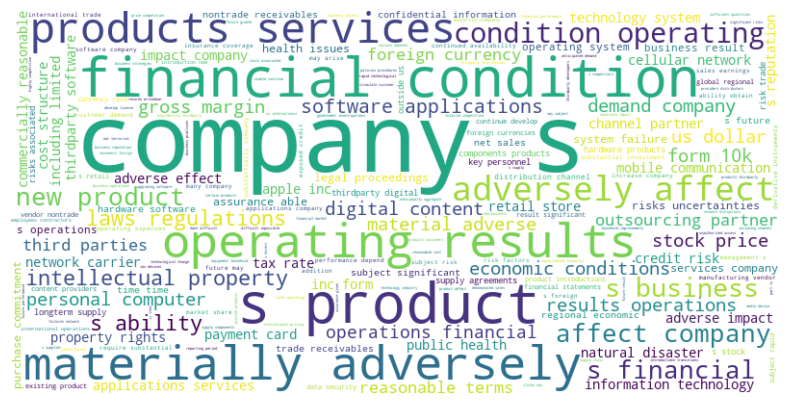

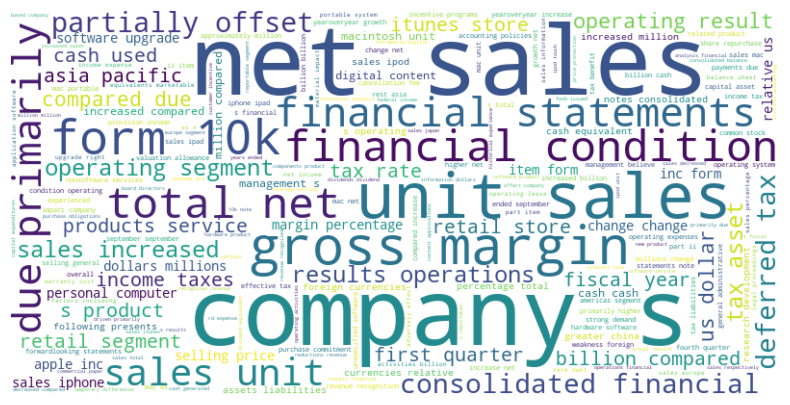

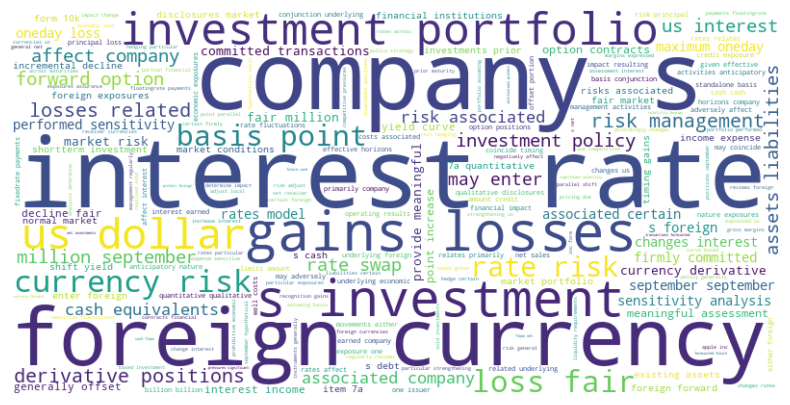

In [52]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
import string
from collections import Counter

# Function to generate word cloud from text file
def generate_word_cloud(file_path):
    # Load and read the text file
    with open(file_path, "r") as file:
        text = file.read()

    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    word_tokens = text.split()
    filtered_text = [word for word in word_tokens if word not in stop_words]

    # Exclude specific words
    excluded_words = ['dtd','copyright','llc','en','html','fe','ed','webfilings','e','vk','g','zip code', 'pagebreak','html' 
                'w','c','en','table','body','par','value','per','securities','exchange','comission', 'company','telephone','number',
                'zip', 'code', 'end', 'page','xbrl','begin','dc','aa','aaa', 'aaa aa','ab','abn','abn amro','abnormal',
                'abo','abs','ac','az','ba','baa','aoci','aol','apb','api','app','ann','anne','amp','amt','anda','bla','bit',
                'bio','bhc','bb','bbb','bbl','bbls','bc','bcf','bcfe','apr','arc','aro','asa','asa','asc','asic','asp','asr',
                'asu','asus','ave','bms','bnp','bny','boe','blvd','bms','boe','bps','bs','btu', 'btus','ca','cad','cal','ccc',
                'cceeff','cdo','cdos','cds','ce','cede','cg','chk','cmsa','col','com','con','conway','ct','dd','de','dan',
                'dana','dea','wti','wto','wv','wyeth','wyoming','xannual','xerox','xi','xii','xiii','xindicate','xiv','xix','xl',
                'xthe','xv','xvi','xvii','xviii', 'xx','xxi','xxx','wi','vt','vs','von''vie','via','vi','var','ta','tab','tam',
                'td','tdr','tdrs','te','sur','ss','sr','sq','sp','sop','sip','sd','sdn','se', 's', 'affected', 'company',
                '__________________________________________ '
                '__________ ']
    filtered_text = [word for word in filtered_text if word not in excluded_words]

    # Remove recurring words (appearing only once)
    word_count = Counter(filtered_text)
    filtered_text = [word for word in filtered_text if word_count[word] > 1]

    # Join the filtered text back into a single string
    filtered_text = ' '.join(filtered_text)

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, max_font_size=100, background_color='white').generate(filtered_text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Generate word cloud for item1a_combined_text.txt
generate_word_cloud("item1a_combined_text.txt")

# Generate word cloud for item7_combined_text.txt
generate_word_cloud("item7_combined_text.txt")

# Generate word cloud for item7a_combined_text.txt
generate_word_cloud("item7a_combined_text.txt")

# Latent Dirichlet allocation (LDA) on Item 1A and 7

In [53]:
import nltk
import re
import string
from gensim import corpora, models
from gensim.models import LdaMulticore
import pyLDAvis.gensim

# Step 1: Preprocessing
with open('item1a_combined_text.txt', 'r') as file:
    documents = [re.sub('[{}]'.format(string.punctuation), '', re.sub(r'\d+', '', d.lower())).split() for d in file.readlines()]

# Perform necessary preprocessing steps on 'documents' (e.g., remove stopwords, lemmatization)
stopwords = nltk.corpus.stopwords.words('english')
excluded_words = ['dtd','copyright','llc','en','html','fe','ed','webfilings','e','vk','g','zip code', 'pagebreak','html' 
                'w','c','en','table','body','par','value','per','securities','exchange','comission', 'company','telephone','number',
                'zip', 'code', 'end', 'page','xbrl','begin','dc','aa','aaa', 'aaa aa','ab','abn','abn amro','abnormal',
                'abo','abs','ac','az','ba','baa','aoci','aol','apb','api','app','ann','anne','amp','amt','anda','bla','bit',
                'bio','bhc','bb','bbb','bbl','bbls','bc','bcf','bcfe','apr','arc','aro','asa','asa','asc','asic','asp','asr',
                'asu','asus','ave','bms','bnp','bny','boe','blvd','bms','boe','bps','bs','btu', 'btus','ca','cad','cal','ccc',
                'cceeff','cdo','cdos','cds','ce','cede','cg','chk','cmsa','col','com','con','conway','ct','dd','de','dan',
                'dana','dea','wti','wto','wv','wyeth','wyoming','xannual','xerox','xi','xii','xiii','xindicate','xiv','xix','xl',
                'xthe','xv','xvi','xvii','xviii', 'xx','xxi','xxx','wi','vt','vs','von''vie','via','vi','var','ta','tab','tam',
                'td','tdr','tdrs','te','sur','ss','sr','sq','sp','sop','sip','sd','sdn','se', 's', 'affected', 'company',
                '__________________________________________ ',
                '__________ ']

# Remove stopwords and excluded words
documents = [[word for word in doc if word not in stopwords and word not in excluded_words] for doc in documents]

# Step 2: Create dictionary and BoW
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(doc) for doc in documents]

# Step 3: Train LDA model
lda_model = LdaMulticore(corpus, num_topics=6, id2word=dictionary, passes=10, workers=2)

# Step 4: Show topics
topics = lda_model.show_topics()
for topic in topics:
    print(topic)

# Step 5: Visualize LDA model using pyLDAvis
pyLDAvis.enable_notebook()
vis_data = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

(0, '0.025*"may" + 0.025*"products" + 0.020*"company\x92s" + 0.019*"foreign" + 0.016*"company’s" + 0.015*"sales" + 0.015*"content" + 0.014*"property" + 0.014*"intellectual" + 0.011*"reasonable"')
(1, '0.025*"may" + 0.018*"company\x92s" + 0.015*"products" + 0.014*"components" + 0.014*"form" + 0.013*"k" + 0.011*"supply" + 0.010*"company’s" + 0.010*"business" + 0.010*"inc"')
(2, '0.022*"could" + 0.019*"laws" + 0.017*"subject" + 0.016*"company\x92s" + 0.015*"company’s" + 0.013*"tax" + 0.012*"regulations" + 0.012*"us" + 0.012*"retail" + 0.012*"international"')
(3, '0.028*"products" + 0.021*"software" + 0.020*"company\x92s" + 0.017*"applications" + 0.017*"thirdparty" + 0.017*"market" + 0.014*"operating" + 0.012*"also" + 0.012*"results" + 0.012*"competitors"')
(4, '0.031*"could" + 0.027*"products" + 0.026*"financial" + 0.024*"company\x92s" + 0.017*"company’s" + 0.017*"materially" + 0.017*"adversely" + 0.016*"services" + 0.016*"new" + 0.015*"results"')
(5, '0.019*"price" + 0.017*"stock" + 0.01

In [54]:
import nltk
import re
import string
from gensim import corpora, models
from gensim.models import LdaMulticore
import pyLDAvis.gensim

# Step 1: Preprocessing
with open('item7_combined_text.txt', 'r') as file:
    documents = [re.sub('[{}]'.format(string.punctuation), '', re.sub(r'\d+', '', d.lower())).split() for d in file.readlines()]

# Perform necessary preprocessing steps on 'documents' (e.g., remove stopwords, lemmatization)
stopwords = nltk.corpus.stopwords.words('english')
excluded_words = ['dtd','copyright','llc','en','html','fe','ed','webfilings','e','vk','g','zip code', 'pagebreak','html' 
                'w','c','en','table','body','par','value','per','securities','exchange','comission', 'company','telephone','number',
                'zip', 'code', 'end', 'page','xbrl','begin','dc','aa','aaa', 'aaa aa','ab','abn','abn amro','abnormal',
                'abo','abs','ac','az','ba','baa','aoci','aol','apb','api','app','ann','anne','amp','amt','anda','bla','bit',
                'bio','bhc','bb','bbb','bbl','bbls','bc','bcf','bcfe','apr','arc','aro','asa','asa','asc','asic','asp','asr',
                'asu','asus','ave','bms','bnp','bny','boe','blvd','bms','boe','bps','bs','btu', 'btus','ca','cad','cal','ccc',
                'cceeff','cdo','cdos','cds','ce','cede','cg','chk','cmsa','col','com','con','conway','ct','dd','de','dan',
                'dana','dea','wti','wto','wv','wyeth','wyoming','xannual','xerox','xi','xii','xiii','xindicate','xiv','xix','xl',
                'xthe','xv','xvi','xvii','xviii', 'xx','xxi','xxx','wi','vt','vs','von''vie','via','vi','var','ta','tab','tam',
                'td','tdr','tdrs','te','sur','ss','sr','sq','sp','sop','sip','sd','sdn','se', 's', 'affected', 'company',
                '__________________________________________ ',
                '__________ ']

# Remove stopwords and excluded words
documents = [[word for word in doc if word not in stopwords and word not in excluded_words] for doc in documents]

# Step 2: Create dictionary and BoW
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(doc) for doc in documents]

# Step 3: Train LDA model
lda_model = LdaMulticore(corpus, num_topics=6, id2word=dictionary, passes=10, workers=2)

# Step 4: Show topics
topics = lda_model.show_topics()
for topic in topics:
    print(topic)

# Step 5: Visualize LDA model using pyLDAvis
pyLDAvis.enable_notebook()
vis_data = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

(0, '0.050*"tax" + 0.032*"income" + 0.026*"assets" + 0.022*"change" + 0.016*"liabilities" + 0.014*"taxes" + 0.013*"deferred" + 0.010*"financial" + 0.010*"valuation" + 0.010*"management"')
(1, '0.052*"billion" + 0.031*"cash" + 0.030*"september" + 0.020*"form" + 0.019*"k" + 0.017*"capital" + 0.014*"used" + 0.013*"program" + 0.013*"years" + 0.012*"payments"')
(2, '0.117*"sales" + 0.090*"net" + 0.032*"iphone" + 0.024*"growth" + 0.024*"unit" + 0.022*"compared" + 0.022*"primarily" + 0.020*"total" + 0.020*"ipad" + 0.019*"increased"')
(3, '0.029*"products" + 0.023*"software" + 0.020*"thirdparty" + 0.017*"stores" + 0.015*"store" + 0.013*"product" + 0.013*"sales" + 0.012*"digital" + 0.012*"new" + 0.011*"content"')
(4, '0.033*"revenue" + 0.024*"software" + 0.018*"millions" + 0.018*"services" + 0.016*"estimated" + 0.015*"price" + 0.013*"company\x92s" + 0.012*"related" + 0.011*"dollars" + 0.011*"future"')
(5, '0.029*"company\x92s" + 0.024*"gross" + 0.021*"results" + 0.016*"financial" + 0.015*"produ

# Processing Text for LLM Inference

In [55]:
import numpy as np

def process_text_file(filename):
    # Read the file
    with open(filename, "r") as f:
        transcript = f.read()

    # Split the text into words
    words = transcript.split(" ")
    num_words = len(words)

    # Split the words into chunks
    chunks = np.array_split(words, 150)

    # Join the words of the first chunk into sentences
    first_chunk_sentences = ' '.join(list(chunks[0]))

    # Return the results as a tuple
    return num_words, first_chunk_sentences

# Process the three text files
num_words_1a, first_chunk_sentences_1a = process_text_file("item1a_combined_text.txt")
num_words_7, first_chunk_sentences_7 = process_text_file("item7_combined_text.txt")
num_words_7a, first_chunk_sentences_7a = process_text_file("item7a_combined_text.txt")

# Print the results
print("item1a_combined_text.txt:")
print("Total number of words:", num_words_1a)
# print("Sentences from the first chunk:", first_chunk_sentences_1a)
print()

print("item7_combined_text.txt:")
print("Total number of words:", num_words_7)
# print("Sentences from the first chunk:", first_chunk_sentences_7)
print()

print("item7a_combined_text.txt:")
print("Total number of words:", num_words_7a)
# print("Sentences from the first chunk:", first_chunk_sentences_7a)

item1a_combined_text.txt:
Total number of words: 124158

item7_combined_text.txt:
Total number of words: 163536

item7a_combined_text.txt:
Total number of words: 27780


# Setting Claude API and Prompts

In [56]:
import anthropic

# Set up the Anthropic client with your API key
client = anthropic.Client(api_key="")

# The text to perform inference on
sentences1a = first_chunk_sentences_1a
sentences7 = first_chunk_sentences_7
sentences7a = first_chunk_sentences_7a

# The question to ask about the text 
question1a = """List the key trends or changes in the company's business operations and financial performance over the past few years based on the information provided in Item 1A (Risk Factors)?"""
question7 = """Based on the (MD&A) section in Item 7, what are the main factors driving the company's revenue growth or decline, and how does the company plan to address these factors going forward?"""
question7a = """According to Disclosures about Market Risk in Item 7A, what are the most significant market risks the company faces, and how does it manage or mitigate these risks?"""

# # Use the Claude model to answer the question based on the given text
# response = client.completions.create(
#     prompt=f"{anthropic.HUMAN_PROMPT} {sentences}\n\nQuestion: {question}\n{anthropic.AI_PROMPT}",
#     model="claude-instant-v1",
#     max_tokens_to_sample=1000,
# )

# # Print out Claude's answer
# print(response["completion"])

In [57]:
from IPython.display import Markdown, display
from anthropic import HUMAN_PROMPT, AI_PROMPT

completion1 = client.completions.create(
    model="claude-2.1",
    max_tokens_to_sample=50,
    prompt=f"{anthropic.HUMAN_PROMPT} {sentences1a}\n\nQuestion: {question1a}\n{anthropic.AI_PROMPT}",
)
Markdown(completion1.completion)

 Unfortunately there is no clear information provided in the excerpt from Item 1A about trends or changes in the company's business operations and financial performance over the past few years. The risk factors section outlines potential risks and challenges the company could face that may impact future

In [58]:
completion2 = client.completions.create(
    model="claude-2.1",
    max_tokens_to_sample=50,
    prompt=f"{anthropic.HUMAN_PROMPT} {sentences7}\n\nQuestion: {question7}\n{anthropic.AI_PROMPT}",
)
Markdown(completion2.completion)

 Based on the MD&A, there are a few key factors driving Apple's revenue growth and declines:

1. iPhone sales - A major driver of revenue. iPhone sales grew 3% in 2017 over 2016, but declined 12% in 2016

In [59]:
completion3 = client.completions.create(
    model="claude-2.1",
    max_tokens_to_sample=50,
    prompt=f"{anthropic.HUMAN_PROMPT} {sentences7a}\n\nQuestion: {question7a}\n{anthropic.AI_PROMPT}",
)
Markdown(completion3.completion)

 Based on the disclosure, the most significant market risks the company faces are:

1. Interest rate risk: Primarily relates to the company's investment portfolio and outstanding debt. The company is most sensitive to fluctuations in U.S. interest rates

In [60]:
from tkinter import Tk, Label
from IPython.display import Markdown

# Create the main window
window = Tk()
window.title("Inferences")

# Create and position the inference labels
label_1a = Label(window, text="Item 1A Inference:")
label_1a.pack()

inference_1a_text = Markdown(completion1.completion).data  # Use the completion object you have
label_1a_text = Label(window, text=inference_1a_text)
label_1a_text.pack()

label_7 = Label(window, text="Item 7 Inference:")
label_7.pack()

inference_7_text = Markdown(completion2.completion).data  # Use the completion object you have
label_7_text = Label(window, text=inference_7_text)
label_7_text.pack()

label_7a = Label(window, text="Item 7A Inference:")
label_7a.pack()

inference_7a_text = Markdown(completion3.completion).data  # Use the completion object you have
label_7a_text = Label(window, text=inference_7a_text)
label_7a_text.pack()

# Start the main loop
window.geometry("800x800") 
window.mainloop()

## OpenAI API execution

In [61]:
# from openai import OpenAI
# client = OpenAI()

# response = client.chat.completions.create(
#   model="gpt-3.5-turbo",
#   messages=[
#     {
#       "role": "system",
#       "content": "How have the company's stated risks evolved over the 26 year period? Are there any recurring themes or new risks that have emerged?"
#     },
#     {
#       "role": "user",
#       "content": sentences
#     }
#   ],
#   temperature=0.,
#   max_tokens=140,
#   top_p=1
# )

In [62]:

# prompt = f"{sentences}\n\ntl;dr:"

# response = openai.completions.create(
#     engine="gpt-3.5-turbo", 
#     prompt=prompt,
#     temperature=0.3, # The temperature controls the randomness of the response, represented as a range from 0 to 1. A lower value of temperature means the API will respond with the first thing that the model sees; a higher value means the model evaluates possible responses that could fit into the context before spitting out the result.
#     max_tokens=140,
#     top_p=1, # Top P controls how many random results the model should consider for completion, as suggested by the temperature dial, thus determining the scope of randomness. Top P’s range is from 0 to 1. A lower value limits creativity, while a higher value expands its horizons.
#     frequency_penalty=0,
#     presence_penalty=1
# )

# response_text = response["choices"][0]["text"]
# response_text

# Deployed Locally using Mercury

In [63]:
pip install mljar-mercury

  Using cached Django-3.2.5-py3-none-any.whl.metadata (3.9 kB)
  Using cached djangorestframework-3.12.4-py3-none-any.whl.metadata (9.9 kB)
Using cached Django-3.2.5-py3-none-any.whl (7.9 MB)
Using cached djangorestframework-3.12.4-py3-none-any.whl (957 kB)
  Attempting uninstall: django
    Found existing installation: Django 4.2.3
    Uninstalling Django-4.2.3:
      Successfully uninstalled Django-4.2.3
  Attempting uninstall: djangorestframework
    Found existing installation: djangorestframework 3.14.0
    Uninstalling djangorestframework-3.14.0:
      Successfully uninstalled djangorestframework-3.14.0
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: celery 5.1.2 has a non-standard dependency specifier pytz>dev. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of celery or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
channels 4.1.0 requires Django>=4.2, but you have django 3.2.5 which is incompatible.
mercury 2.3.10 requires django==4.2.3, but you have django 3.2.5 which is incompatible.
mercury 2.3.10 requires djangorestframework==3.14.0, but you have djangorestframework 3.12.4 which is incompatible.


In [64]:
pip install mercury

  Using cached Django-4.2.3-py3-none-any.whl.metadata (4.1 kB)
  Using cached djangorestframework-3.14.0-py3-none-any.whl.metadata (10 kB)
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: celery 5.1.2 has a non-standard dependency specifier pytz>dev. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of celery or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mljar-mercury 1.1.6 requires django==3.2.5, but you have django 4.2.3 which is incompatible.
mljar-mercury 1.1.6 requires djangorestframework==3.12.4, but you have djangorestframework 3.14.0 which is incompatible.


Using cached Django-4.2.3-py3-none-any.whl (8.0 MB)
Using cached djangorestframework-3.14.0-py3-none-any.whl (1.1 MB)
  Attempting uninstall: django
    Found existing installation: Django 3.2.5
    Uninstalling Django-3.2.5:
      Successfully uninstalled Django-3.2.5
  Attempting uninstall: djangorestframework
    Found existing installation: djangorestframework 3.12.4
    Uninstalling djangorestframework-3.12.4:
      Successfully uninstalled djangorestframework-3.12.4
